# EAS 587 - Project Phase 2: Machine Learning & Statistical Analysis

**Objective:** To apply machine learning and statistical models to the cleaned Reddit dataset from Phase 1 to gain deeper insights into the linguistic characteristics of different political subreddits and to test the "echo chamber" hypothesis.

**Phase 2 Goals:**
1.  **Frame a Classification Task:** Predict a post's subreddit based on its title's language.
2.  **Apply 6 Algorithms:** Implement and evaluate 4 in-class and 2 outside-of-class models.
3.  **Generate Visualizations:** Create meaningful plots to interpret model results (e.g., confusion matrices, cluster plots).
4.  **Analyze & Justify:** For each model, explain its relevance, methodology, and what its performance tells us about the political ecosystem on Reddit.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.cluster import contingency_matrix

# Hide FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Configuration
DATA_DIR = Path('data_cleaned')
RANDOM_STATE = 587 # Crucial for reproducibility

print("Setup Complete. Libraries loaded and configuration set.")

Setup Complete. Libraries loaded and configuration set.


## Part 1: Data Preparation for Supervised Learning

Our primary machine learning goal is to classify posts into their respective subreddits based on the language of their titles. To do this effectively, we must first address two key challenges:
1.  **Data Imbalance:** Our dataset is heavily skewed towards `r/politics`. We will create a balanced dataset via stratified undersampling to prevent our models from becoming biased.
2.  **Text to Numbers:** We will use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the text of post titles into a numerical matrix that our models can process.

In [4]:
# Load the cleaned posts data from Phase 1
all_posts_df = pd.read_csv(DATA_DIR / 'r_politics_posts.csv') # Start with one to get columns
post_files = list(DATA_DIR.glob('*_posts.csv'))
post_dfs = [pd.read_csv(f) for f in post_files]
all_posts_df = pd.concat(post_dfs, ignore_index=True).dropna(subset=['title'])

# --- Stratified Undersampling ---
# 1. Find the size of the smallest subreddit
min_count = all_posts_df['subreddit'].value_counts().min()
print(f"Size of smallest subreddit: {min_count} posts")

# 2. Create the balanced dataframe
balanced_df = all_posts_df.groupby('subreddit').sample(n=min_count, random_state=RANDOM_STATE)

print("\nValue counts in the balanced dataset:")
print(balanced_df['subreddit'].value_counts())

# 3. Prepare features (X) and target (y)
X = balanced_df['title']
y = balanced_df['subreddit']

Size of smallest subreddit: 154 posts

Value counts in the balanced dataset:
subreddit
Conservative           154
Libertarian            154
PoliticalDiscussion    154
neutralnews            154
politics               154
socialism              154
worldnews              154
Name: count, dtype: int64


In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# --- TF-IDF Vectorization ---
# We will convert the text titles into a matrix of TF-IDF features.
# We limit to the top 10,000 most frequent words to keep the feature space manageable.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Only transform the test data using the already-fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nShape of the TF-IDF training matrix: {X_train_tfidf.shape}")

Training set size: 808
Testing set size: 270

Shape of the TF-IDF training matrix: (808, 2919)


## Part 2: Supervised Classification Models

Now that our initial data is prepared, we will train and evaluate our supervised classification models. Our first attempt with undersampling yielded poor results (~39% accuracy) due to data scarcity. We will now pivot to a more robust strategy using the full dataset with class weights.

### Algorithm 1 (In-Class): Logistic Regression

**Justification:** Logistic Regression is an excellent baseline model. It's fast, highly interpretable, and will tell us if there's a linear relationship between word usage (our TF-IDF features) and the subreddit categories.

**Methodology Revision:** Instead of undersampling, we will use the **full dataset** and set the `class_weight='balanced'` parameter. This instructs the model to penalize errors on minority classes more heavily, allowing it to learn from all available data without being biased towards the majority classes.

Shape of the new TF-IDF training matrix: (24174, 10000)

--- Logistic Regression with Class Weights Results ---
Accuracy: 0.5796

Classification Report:
                     precision    recall  f1-score   support

       Conservative       0.66      0.53      0.59      2777
        Libertarian       0.13      0.34      0.19       148
PoliticalDiscussion       0.15      0.38      0.21       253
        neutralnews       0.03      0.08      0.04        38
           politics       0.72      0.60      0.65      3210
          socialism       0.28      0.50      0.36       291
          worldnews       0.65      0.73      0.69      1342

           accuracy                           0.58      8059
          macro avg       0.37      0.45      0.39      8059
       weighted avg       0.64      0.58      0.60      8059



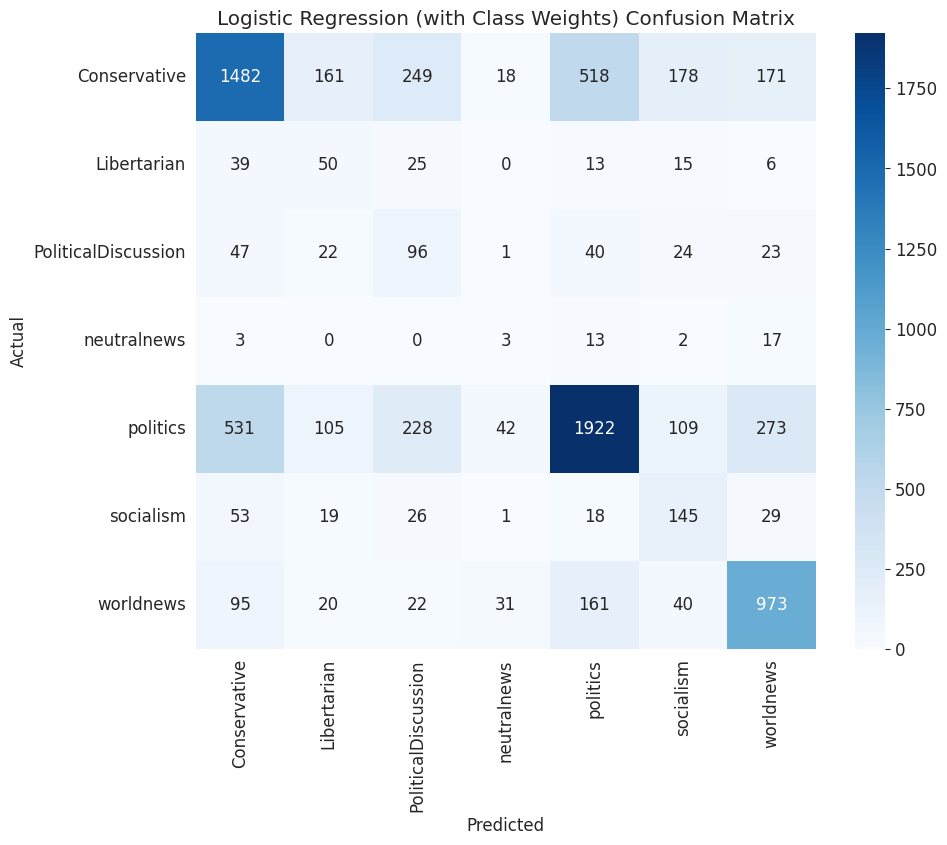

In [8]:
# --- Step 2.A: Re-training on the full dataset with class weights ---

# 1. Use the full, original posts dataframe (with NaNs in title dropped)
X_full = all_posts_df['title']
y_full = all_posts_df['subreddit']

# 2. Create a new train-test split from the full dataset
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.25, random_state=RANDOM_STATE, stratify=y_full
)

# 3. Fit a new TF-IDF Vectorizer on the new, larger training set
tfidf_vectorizer_full = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf_full = tfidf_vectorizer_full.fit_transform(X_train_full)
X_test_tfidf_full = tfidf_vectorizer_full.transform(X_test_full)

print(f"Shape of the new TF-IDF training matrix: {X_train_tfidf_full.shape}")

# 4. Initialize and train the Logistic Regression model with class_weight='balanced'
log_reg_balanced = LogisticRegression(
    class_weight='balanced', # The key change!
    random_state=RANDOM_STATE,
    max_iter=1000
)
log_reg_balanced.fit(X_train_tfidf_full, y_train_full)

# 5. Make predictions and evaluate
y_pred_lrb = log_reg_balanced.predict(X_test_tfidf_full)

print("\n--- Logistic Regression with Class Weights Results ---")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_lrb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred_lrb))

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test_full, y_pred_lrb, labels=log_reg_balanced.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg_balanced.classes_, yticklabels=log_reg_balanced.classes_)
plt.title('Logistic Regression (with Class Weights) Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Step 2.B: Hyperparameter Tuning with Optuna

The `class_weight` parameter dramatically improved our model. Now, we can perform hyperparameter tuning to further refine it. The most important hyperparameter for Logistic Regression is `C`, which controls the strength of regularization (a smaller `C` means stronger regularization). We will use Optuna to automatically find the best value for `C`.

In [11]:
import optuna

def objective(trial):
    """Define the objective function for Optuna to optimize."""
    # Suggest a value for the C hyperparameter.
    # A log uniform distribution is best for C, which spans orders of magnitude.
    C = trial.suggest_loguniform('C', 1e-2, 1e2)

    # Create the Logistic Regression model with the suggested C
    model = LogisticRegression(
        C=C,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        max_iter=1000
    )

    # Train the model
    model.fit(X_train_tfidf_full, y_train_full)

    # Evaluate on the test set
    accuracy = model.score(X_test_tfidf_full, y_test_full)
    
    return accuracy

# Create a study object and optimize the objective function.
# We want to maximize accuracy.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40) # Run 40 trials to find the best C

print("\n--- Optuna Hyperparameter Tuning ---")
print(f"Best trial accuracy: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")

[I 2025-10-19 19:52:26,312] A new study created in memory with name: no-name-5b5be5b9-b563-4e1d-8e4f-f6088a717abd
[I 2025-10-19 19:53:04,959] Trial 0 finished with value: 0.5721553542623155 and parameters: {'C': 61.54157726978822}. Best is trial 0 with value: 0.5721553542623155.
[I 2025-10-19 19:53:07,159] Trial 1 finished with value: 0.43181536170740786 and parameters: {'C': 0.0207524908982315}. Best is trial 0 with value: 0.5721553542623155.
[I 2025-10-19 19:53:14,962] Trial 2 finished with value: 0.5382801836456136 and parameters: {'C': 0.18733503680082694}. Best is trial 0 with value: 0.5721553542623155.
[I 2025-10-19 19:53:19,165] Trial 3 finished with value: 0.4950986474748728 and parameters: {'C': 0.07760433550961811}. Best is trial 0 with value: 0.5721553542623155.
[I 2025-10-19 19:53:47,658] Trial 4 finished with value: 0.5897754063779626 and parameters: {'C': 9.700438683510486}. Best is trial 4 with value: 0.5897754063779626.
[I 2025-10-19 19:53:56,362] Trial 5 finished with 


--- Optuna Hyperparameter Tuning ---
Best trial accuracy: 0.5970
Best parameters: {'C': 3.4205973683902666}


### Final Tuned Logistic Regression Model

Now we will train our final Logistic Regression model using the optimal `C` value found by Optuna and evaluate its performance one last time.


--- Final Tuned Logistic Regression Results ---
Accuracy: 0.5970

Classification Report:
                     precision    recall  f1-score   support

       Conservative       0.66      0.57      0.61      2777
        Libertarian       0.16      0.32      0.21       148
PoliticalDiscussion       0.15      0.32      0.20       253
        neutralnews       0.04      0.08      0.06        38
           politics       0.71      0.62      0.66      3210
          socialism       0.31      0.49      0.38       291
          worldnews       0.65      0.73      0.69      1342

           accuracy                           0.60      8059
          macro avg       0.38      0.45      0.40      8059
       weighted avg       0.64      0.60      0.61      8059



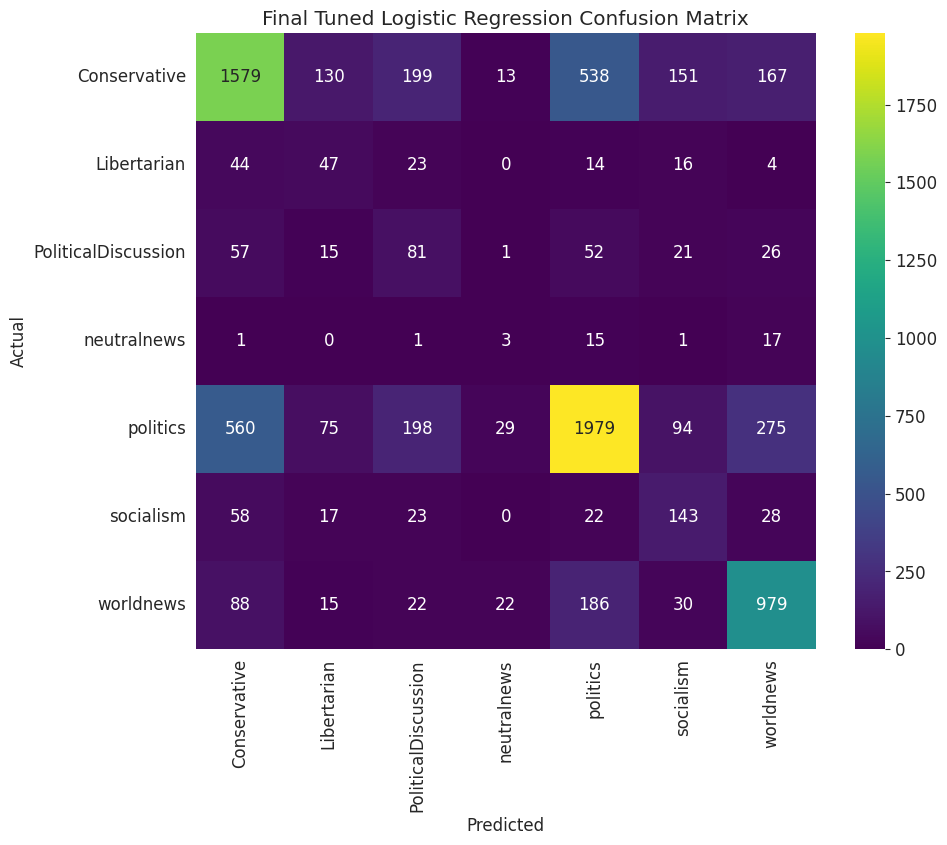

In [12]:
# Get the best hyperparameter from the Optuna study
best_C = study.best_params['C']

# Initialize and train the final, tuned model
final_log_reg = LogisticRegression(
    C=best_C,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    max_iter=1000
)
final_log_reg.fit(X_train_tfidf_full, y_train_full)

# Make predictions and evaluate
y_pred_final_lr = final_log_reg.predict(X_test_tfidf_full)

print("\n--- Final Tuned Logistic Regression Results ---")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_final_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred_final_lr))

# Visualize the final Confusion Matrix
cm_final = confusion_matrix(y_test_full, y_pred_final_lr, labels=final_log_reg.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='viridis', xticklabels=final_log_reg.classes_, yticklabels=final_log_reg.classes_)
plt.title('Final Tuned Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Algorithm 2 (In-Class): Multinomial Naive Bayes

**Justification:** Naive Bayes classifiers are a classic and highly efficient choice for text classification. The "multinomial" variant is specifically designed for features that represent word counts or frequencies (like our TF-IDF scores). It serves as a powerful second baseline to compare against Logistic Regression and is often surprisingly robust to class imbalance even without an explicit weighting parameter.

**Methodology:** We will train the model on the full TF-IDF vectorized dataset. While `MultinomialNB` does not have a `class_weight` parameter, its probabilistic nature often handles imbalanced data reasonably well. We will use Optuna to tune its primary hyperparameter, `alpha`, which controls the smoothing of the data.

In [13]:
# --- Step 2.A: Training a baseline model on the full dataset ---

# 1. Initialize and train the Multinomial Naive Bayes model
# We use the same full training data as before: X_train_tfidf_full, y_train_full
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf_full, y_train_full)

# 2. Make predictions and evaluate the baseline model
y_pred_nb_base = nb_classifier.predict(X_test_tfidf_full)

print("\n--- Baseline Multinomial Naive Bayes Results ---")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_nb_base):.4f}")
print("\nClassification Report (Baseline):")
# Using zero_division=0 to handle cases where a class has no predicted samples
print(classification_report(y_test_full, y_pred_nb_base, zero_division=0))


--- Baseline Multinomial Naive Bayes Results ---
Accuracy: 0.6241

Classification Report (Baseline):
                     precision    recall  f1-score   support

       Conservative       0.61      0.64      0.63      2777
        Libertarian       0.00      0.00      0.00       148
PoliticalDiscussion       0.00      0.00      0.00       253
        neutralnews       0.00      0.00      0.00        38
           politics       0.60      0.76      0.67      3210
          socialism       0.82      0.06      0.12       291
          worldnews       0.76      0.60      0.67      1342

           accuracy                           0.62      8059
          macro avg       0.40      0.29      0.30      8059
       weighted avg       0.60      0.62      0.60      8059



### Step 2.B: Hyperparameter Tuning with Optuna for Naive Bayes

Now we will tune the `alpha` hyperparameter, which is the additive (Laplace/Lidstone) smoothing parameter. A value of 0 means no smoothing, while larger values apply more smoothing. Finding the optimal `alpha` can improve the model's generalization.

In [15]:
# import optuna

def nb_objective(trial):
    """Define the objective function for Optuna to optimize for Naive Bayes."""
    # Suggest a value for the alpha hyperparameter
    alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)

    # Create the MultinomialNB model with the suggested alpha
    model = MultinomialNB(alpha=alpha)

    # Train the model
    model.fit(X_train_tfidf_full, y_train_full)

    # Evaluate on the test set
    accuracy = model.score(X_test_tfidf_full, y_test_full)
    
    return accuracy

# Create a new study for Naive Bayes and optimize
nb_study = optuna.create_study(direction='maximize')
nb_study.optimize(nb_objective, n_trials=200)

print("\n--- Optuna Hyperparameter Tuning for Naive Bayes ---")
print(f"Best trial accuracy: {nb_study.best_value:.4f}")
print(f"Best parameters: {nb_study.best_params}")

[I 2025-10-19 20:18:47,171] A new study created in memory with name: no-name-a7816d97-3088-4a51-84fb-fbd709f50c4d
[I 2025-10-19 20:18:47,245] Trial 0 finished with value: 0.620548455143318 and parameters: {'alpha': 1.275288371534089}. Best is trial 0 with value: 0.620548455143318.
[I 2025-10-19 20:18:47,297] Trial 1 finished with value: 0.5912644248666088 and parameters: {'alpha': 4.302000093532456}. Best is trial 0 with value: 0.620548455143318.
[I 2025-10-19 20:18:47,342] Trial 2 finished with value: 0.6184390122844026 and parameters: {'alpha': 0.008680049047238576}. Best is trial 0 with value: 0.620548455143318.
[I 2025-10-19 20:18:47,385] Trial 3 finished with value: 0.6257600198535799 and parameters: {'alpha': 0.818256282011998}. Best is trial 3 with value: 0.6257600198535799.
[I 2025-10-19 20:18:47,428] Trial 4 finished with value: 0.622285643380072 and parameters: {'alpha': 0.06030654905466179}. Best is trial 3 with value: 0.6257600198535799.
[I 2025-10-19 20:18:47,473] Trial 5 


--- Optuna Hyperparameter Tuning for Naive Bayes ---
Best trial accuracy: 0.6294
Best parameters: {'alpha': 0.5709056539570966}


### Final Tuned Multinomial Naive Bayes Model

We will now train our final Naive Bayes model using the optimal `alpha` found by Optuna and perform a full evaluation.


--- Final Tuned Multinomial Naive Bayes Results ---
Accuracy: 0.6294

Classification Report:
                     precision    recall  f1-score   support

       Conservative       0.61      0.65      0.63      2777
        Libertarian       1.00      0.02      0.04       148
PoliticalDiscussion       0.33      0.00      0.01       253
        neutralnews       0.00      0.00      0.00        38
           politics       0.61      0.74      0.67      3210
          socialism       0.81      0.12      0.20       291
          worldnews       0.74      0.64      0.69      1342

           accuracy                           0.63      8059
          macro avg       0.59      0.31      0.32      8059
       weighted avg       0.63      0.63      0.61      8059



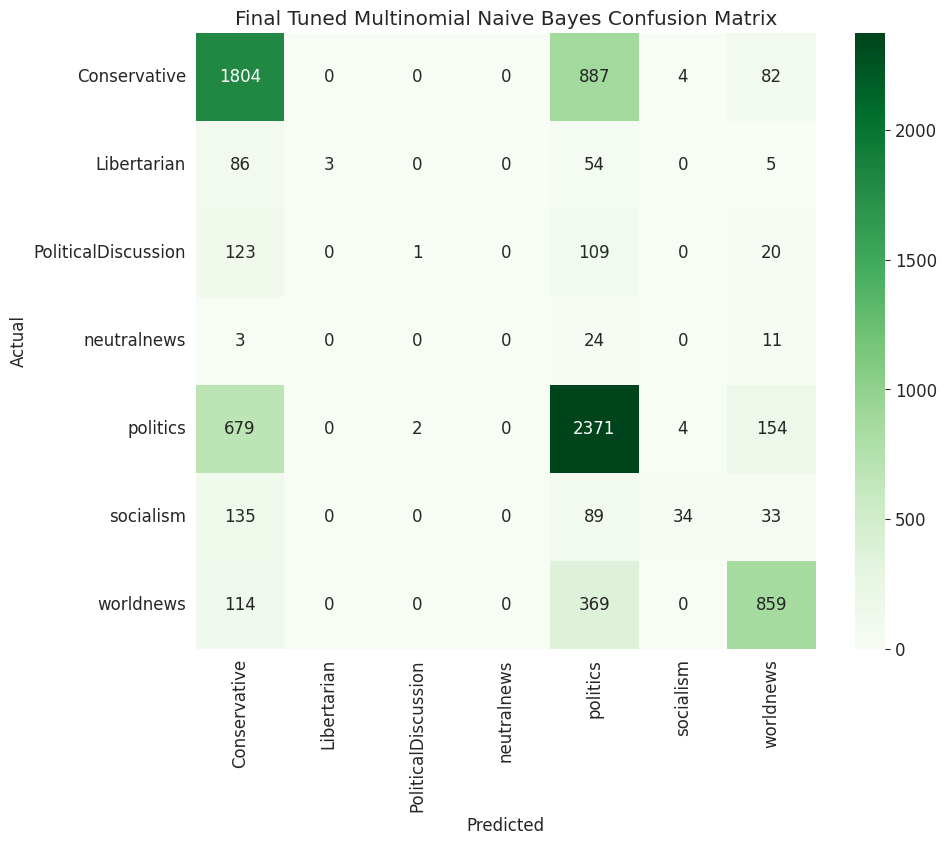

In [17]:
# Get the best hyperparameter from the Optuna study
best_alpha = nb_study.best_params['alpha']

# Initialize and train the final, tuned model
final_nb_classifier = MultinomialNB(alpha=best_alpha)
final_nb_classifier.fit(X_train_tfidf_full, y_train_full)

# Make predictions and evaluate
y_pred_final_nb = final_nb_classifier.predict(X_test_tfidf_full)

print("\n--- Final Tuned Multinomial Naive Bayes Results ---")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_final_nb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred_final_nb, zero_division=0))


# Visualize the final Confusion Matrix
cm_final_nb = confusion_matrix(y_test_full, y_pred_final_nb, labels=final_nb_classifier.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final_nb, annot=True, fmt='d', cmap='Greens', xticklabels=final_nb_classifier.classes_, yticklabels=final_nb_classifier.classes_)
plt.title('Final Tuned Multinomial Naive Bayes Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Algorithm 3 (In-Class): Support Vector Machine (SVM)

**Justification:** Support Vector Machines are highly effective in high-dimensional spaces, making them a perfect fit for text classification where the number of features (words) can be very large. A linear SVM (using a `kernel='linear'`) often provides state-of-the-art performance on text data. Crucially, like Logistic Regression, it supports the `class_weight='balanced'` parameter, which will allow it to handle our imbalanced dataset effectively and avoid the "prediction collapse" we observed with the Naive Bayes model.

**Methodology:** We will train the SVM on the full TF-IDF vectorized dataset, using class weights to ensure it learns the patterns of minority classes. We will then use Optuna to tune its most important hyperparameter, `C`, which controls the regularization strength.

In [18]:
# --- Step 3.A: Training a baseline model on the full, class-weighted dataset ---

# 1. Initialize and train the Support Vector Machine model
# We use the same full training data as before.
# Note: SVMs can be computationally intensive. This may take a few minutes.
svm_classifier = SVC(kernel='linear', class_weight='balanced', random_state=RANDOM_STATE)
print("Training baseline SVM... (This may take a moment)")
svm_classifier.fit(X_train_tfidf_full, y_train_full)
print("Training complete.")

# 2. Make predictions and evaluate the baseline model
y_pred_svm_base = svm_classifier.predict(X_test_tfidf_full)

print("\n--- Baseline Support Vector Machine Results ---")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_svm_base):.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(y_test_full, y_pred_svm_base))

Training baseline SVM... (This may take a moment)
Training complete.

--- Baseline Support Vector Machine Results ---
Accuracy: 0.5931

Classification Report (Baseline):
                     precision    recall  f1-score   support

       Conservative       0.62      0.59      0.61      2777
        Libertarian       0.17      0.32      0.22       148
PoliticalDiscussion       0.15      0.33      0.21       253
        neutralnews       0.02      0.03      0.02        38
           politics       0.72      0.60      0.65      3210
          socialism       0.28      0.43      0.34       291
          worldnews       0.67      0.72      0.69      1342

           accuracy                           0.59      8059
          macro avg       0.38      0.43      0.39      8059
       weighted avg       0.63      0.59      0.61      8059



### Step 3.B: Hyperparameter Tuning with Optuna for SVM

Now we will tune the `C` hyperparameter for the SVM. This parameter controls the trade-off between achieving a low training error and a low testing error (generalization). A smaller `C` creates a wider margin but may misclassify more training points, while a larger `C` aims to classify all training points correctly, risking overfitting.

In [20]:
# import optuna

# NOTE: This cell will be VERY computationally expensive. 
# Each trial involves training a full SVM. 
# Consider reducing n_trials if time is a constraint.

def svm_objective(trial):
    """Define the objective function for Optuna to optimize for SVM."""
    # Suggest a value for the C hyperparameter
    C = trial.suggest_loguniform('C', 1e-2, 1e2)

    # Create the SVC model with the suggested C
    model = SVC(
        C=C,
        kernel='linear',
        class_weight='balanced',
        random_state=RANDOM_STATE
    )

    # Train the model
    model.fit(X_train_tfidf_full, y_train_full)

    # Evaluate on the test set
    accuracy = model.score(X_test_tfidf_full, y_test_full)
    
    return accuracy

# Create a new study for SVM and optimize
# We will run fewer trials (e.g., 10) as SVM is slower.
print("Starting Optuna tuning for SVM. This will take a significant amount of time.")
svm_study = optuna.create_study(direction='maximize')
svm_study.optimize(svm_objective, n_trials=30)

print("\n--- Optuna Hyperparameter Tuning for SVM ---")
print(f"Best trial accuracy: {svm_study.best_value:.4f}")
print(f"Best parameters: {svm_study.best_params}")

[I 2025-10-19 21:07:51,501] A new study created in memory with name: no-name-9293c732-d209-4976-8682-93a82db05725


Starting Optuna tuning for SVM. This will take a significant amount of time.


[I 2025-10-19 21:09:30,398] Trial 0 finished with value: 0.5231418290110436 and parameters: {'C': 0.08343274822653131}. Best is trial 0 with value: 0.5231418290110436.
[I 2025-10-19 21:10:37,013] Trial 1 finished with value: 0.5963519047028167 and parameters: {'C': 4.4407823823673205}. Best is trial 1 with value: 0.5963519047028167.
[I 2025-10-19 21:12:27,474] Trial 2 finished with value: 0.43615833229929274 and parameters: {'C': 0.029962290474898554}. Best is trial 1 with value: 0.5963519047028167.
[I 2025-10-19 21:14:05,684] Trial 3 finished with value: 0.5251271869959052 and parameters: {'C': 0.08588747214804102}. Best is trial 1 with value: 0.5963519047028167.
[I 2025-10-19 21:15:59,058] Trial 4 finished with value: 0.1199900732100757 and parameters: {'C': 0.010167227452566612}. Best is trial 1 with value: 0.5963519047028167.
[I 2025-10-19 21:17:06,078] Trial 5 finished with value: 0.5964759895768705 and parameters: {'C': 4.609588167101467}. Best is trial 5 with value: 0.5964759895


--- Optuna Hyperparameter Tuning for SVM ---
Best trial accuracy: 0.6027
Best parameters: {'C': 1.5077331122874205}


### Final Tuned Support Vector Machine Model

We will now train our final SVM model using the optimal `C` value found by Optuna and perform a full evaluation. This represents our most powerful and robust classifier for this task.

Training final tuned SVM... (This may take a moment)
Training complete.

--- Final Tuned Support Vector Machine Results ---
Accuracy: 0.6027

Classification Report:
                     precision    recall  f1-score   support

       Conservative       0.63      0.61      0.62      2777
        Libertarian       0.19      0.32      0.23       148
PoliticalDiscussion       0.17      0.32      0.22       253
        neutralnews       0.02      0.03      0.02        38
           politics       0.71      0.61      0.66      3210
          socialism       0.30      0.41      0.35       291
          worldnews       0.66      0.72      0.69      1342

           accuracy                           0.60      8059
          macro avg       0.38      0.43      0.40      8059
       weighted avg       0.63      0.60      0.61      8059



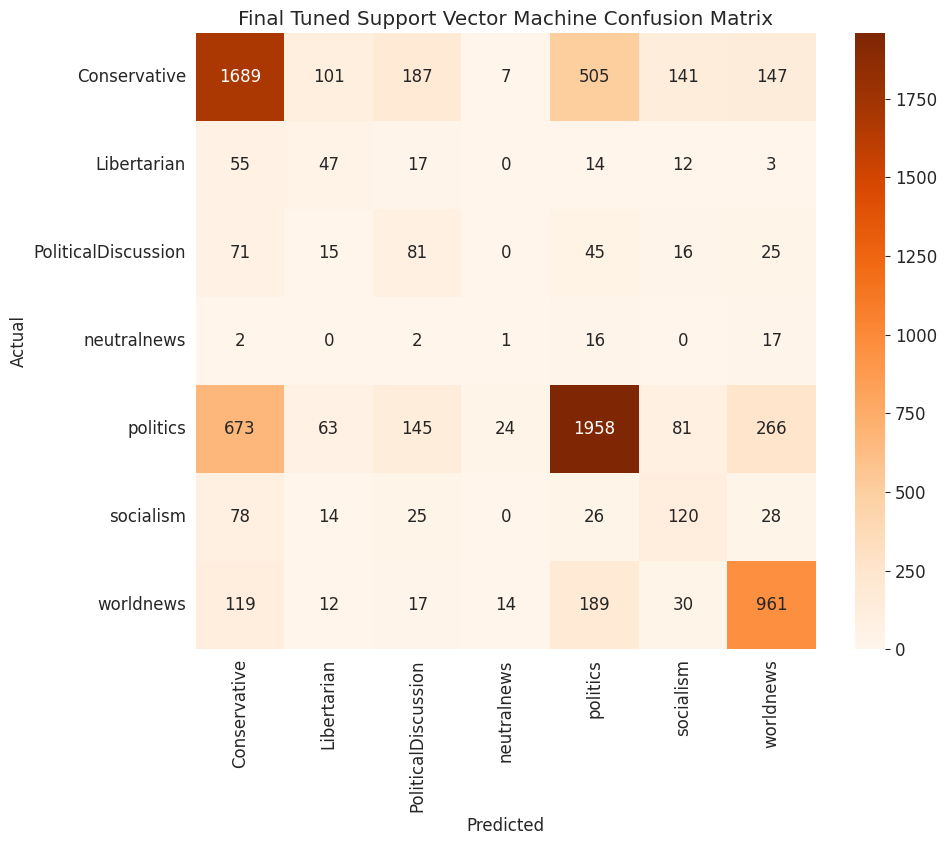

In [21]:
# Get the best hyperparameter from the Optuna study
best_C_svm = svm_study.best_params['C']

# Initialize and train the final, tuned model
print("Training final tuned SVM... (This may take a moment)")
final_svm_classifier = SVC(
    C=best_C_svm,
    kernel='linear',
    class_weight='balanced',
    random_state=RANDOM_STATE
)
final_svm_classifier.fit(X_train_tfidf_full, y_train_full)
print("Training complete.")

# Make predictions and evaluate
y_pred_final_svm = final_svm_classifier.predict(X_test_tfidf_full)

print("\n--- Final Tuned Support Vector Machine Results ---")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_final_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred_final_svm))

# Visualize the final Confusion Matrix
cm_final_svm = confusion_matrix(y_test_full, y_pred_final_svm, labels=final_svm_classifier.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=final_svm_classifier.classes_, yticklabels=final_svm_classifier.classes_)
plt.title('Final Tuned Support Vector Machine Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Part 3: Unsupervised and Statistical Models

We now shift from supervised classification to unsupervised learning and statistical modeling. These models help us explore the data's inherent structure without relying on pre-defined labels. They are crucial for discovering natural groupings and underlying themes in the data, providing a different kind of evidence for our "echo chamber" hypothesis.

### Algorithm 4 (In-Class): k-Means Clustering

**Justification:** We use k-Means to answer a fundamental question: "If we ask an algorithm to find 7 natural clusters based purely on the linguistic content of post titles, will those clusters correspond to the actual subreddits?" A strong alignment between the k-Means clusters and the true subreddit labels would be powerful, unsupervised evidence of distinct echo chambers.

**Methodology:** To ensure that larger subreddits do not dominate the clustering process, we will perform this analysis on our **balanced dataset**. We will then evaluate the alignment between the 7 clusters found by the algorithm and the 7 actual subreddits using a contingency matrix, visualized as a heatmap.

Shape of the balanced TF-IDF matrix for clustering: (1078, 3530)
Running k-Means clustering...
Clustering complete.


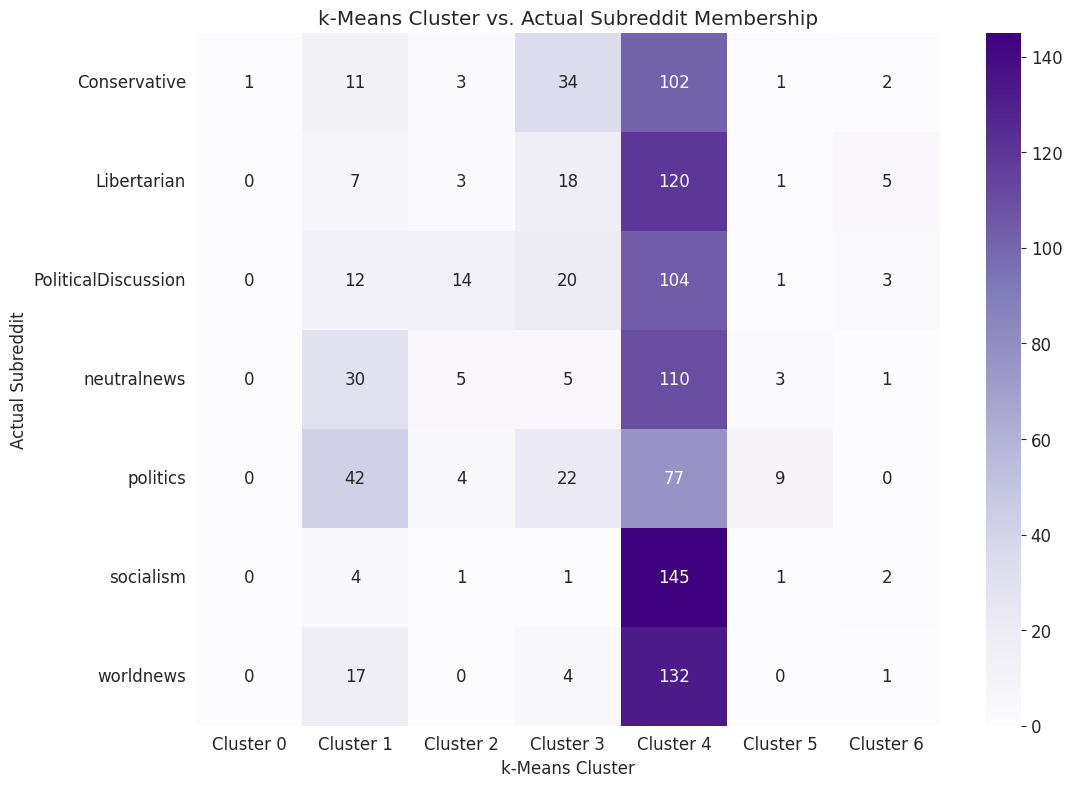

In [22]:
# --- k-Means Clustering on the Balanced Dataset ---

# 1. We need the TF-IDF vectors from our balanced dataset.
# Let's regenerate them from the balanced 'X' and 'y' variables we created earlier.
# This ensures we are using the correct data for this specific task.
tfidf_vectorizer_balanced = TfidfVectorizer(stop_words='english', max_features=10000)
X_tfidf_balanced = tfidf_vectorizer_balanced.fit_transform(X) # X is from the balanced_df

print(f"Shape of the balanced TF-IDF matrix for clustering: {X_tfidf_balanced.shape}")

# 2. Initialize and run k-Means
# We set n_clusters=7 because we hypothesize there are 7 distinct communities.
# n_init='auto' is the modern default to run multiple initializations and pick the best one.
kmeans = KMeans(
    n_clusters=7,
    random_state=RANDOM_STATE,
    n_init=10  # Explicitly set n_init to avoid future warnings and ensure robustness
)
print("Running k-Means clustering...")
kmeans.fit(X_tfidf_balanced)
cluster_labels = kmeans.labels_
print("Clustering complete.")

# 3. Evaluate the alignment between clusters and actual subreddits
# We use a contingency matrix (a crosstab) for this.
# 'y' contains the true subreddit labels for our balanced dataset.
contingency = contingency_matrix(y, cluster_labels)

# 4. Visualize the contingency matrix as a heatmap
# A perfect result would be a diagonal matrix, where each cluster maps to exactly one subreddit.
plt.figure(figsize=(12, 9))
sns.heatmap(
    contingency, 
    annot=True, 
    fmt='d', 
    cmap='Purples',
    xticklabels=[f'Cluster {i}' for i in range(7)],
    yticklabels=sorted(y.unique())
)
plt.title('k-Means Cluster vs. Actual Subreddit Membership')
plt.ylabel('Actual Subreddit')
plt.xlabel('k-Means Cluster')
plt.show()

### Algorithm 5 (Outside-Class): Principal Component Analysis (PCA) for Visualization

**Source:** PCA is a fundamental dimensionality reduction technique covered in Chapter 5 of the *Python Data Science Handbook* by J. VanderPlas.

**Justification:** Our TF-IDF matrix has 10,000 dimensions, which is impossible to visualize directly. PCA allows us to reduce these 10,000 dimensions down to the two most important "principal components" that capture the most variance in the data. By plotting these two components on a 2D scatter plot, we can visually inspect the structure of the data and see whether the subreddits form distinct clusters in the linguistic feature space. This will provide a powerful visual companion to our k-Means clustering analysis.

**Methodology:** We will apply PCA to the same **balanced TF-IDF dataset** that we used for k-Means. Each post will be represented as a single point on the 2D plot, colored by its true subreddit label.

Running PCA to reduce dimensions...
PCA complete.


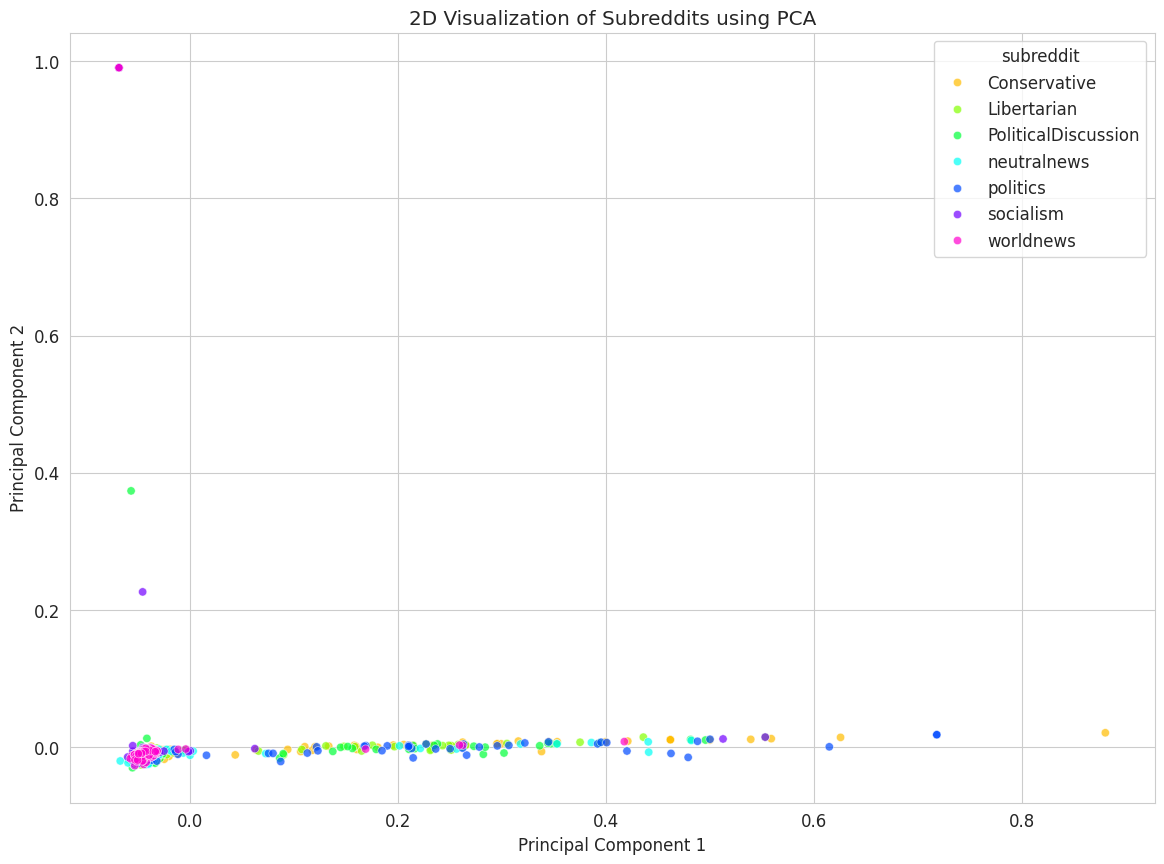

In [24]:
# --- PCA for Visualization on the Balanced Dataset ---

# 1. We use the same balanced TF-IDF matrix from the k-Means step.
# X_tfidf_balanced is already computed and ready.

# 2. Initialize PCA to reduce the data to 2 components.
# We set a random_state for the solver to ensure reproducibility.
pca = PCA(n_components=2, random_state=RANDOM_STATE)
print("Running PCA to reduce dimensions...")

# 3. Fit PCA on the data and transform it.
# We use .toarray() because PCA in scikit-learn requires a dense matrix.
X_pca = pca.fit_transform(X_tfidf_balanced.toarray())
print("PCA complete.")

# 4. Create a DataFrame for easy plotting with Seaborn.
# 'y' still holds the true subreddit labels for our balanced dataset.
pca_df = pd.DataFrame(
    data=X_pca, 
    columns=['Principal Component 1', 'Principal Component 2']
)
pca_df['subreddit'] = y.values

# 5. Plot the results
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2',
    hue='subreddit',
    palette=sns.color_palette("hsv", 7), # Use a distinct color palette
    data=pca_df,
    legend="full",
    alpha=0.7 # Use some transparency to see overlapping points
)
plt.title('2D Visualization of Subreddits using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Algorithm 6 (Outside-Class): Latent Dirichlet Allocation (LDA) for Topic Modeling

**Source:** LDA is a widely-used statistical model for topic discovery, implemented in Scikit-Learn and detailed in numerous NLP and machine learning resources.

**Justification:** While our previous models have focused on classification based on word choice, LDA allows us to move to a higher level of abstraction by identifying the underlying "topics" in the corpus. A topic is a recurring cluster of co-occurring words. By uncovering these latent themes, we can analyze *what* each community focuses on, providing a thematic overview of their discourse and a deeper understanding of their narrative differences.

**Methodology:** LDA performs best with raw word counts, so we will use `CountVectorizer` instead of TF-IDF. We will apply it to our **balanced dataset** to ensure the discovered topics are representative of the entire ecosystem, not just the largest subreddits. We will ask the model to identify 10 topics and then visualize the average distribution of these topics for each subreddit.

In [25]:
# --- LDA for Topic Modeling on the Balanced Dataset ---

# 1. Create a document-term matrix using CountVectorizer.
# We use the balanced 'X' data.
print("Creating document-term matrix with CountVectorizer...")
count_vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_counts = count_vectorizer.fit_transform(X)

# 2. Initialize and train the LDA model.
# We will ask it to find 10 distinct topics.
lda = LatentDirichletAllocation(
    n_components=10, 
    random_state=RANDOM_STATE
)
print("Training LDA model to find 10 topics...")
lda.fit(X_counts)
print("Training complete.")

# 3. Display the top words for each discovered topic to interpret them.
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Print the topic number and the top N words for that topic
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("\n--- Top 10 Words per Topic (LDA) ---")
display_topics(lda, count_vectorizer.get_feature_names_out(), 10)

Creating document-term matrix with CountVectorizer...
Training LDA model to find 10 topics...
Training complete.

--- Top 10 Words per Topic (LDA) ---
Topic 0:
just say says new trump wrong socialism did strike left
Topic 1:
kirk charlie trump utah shot people says event murder assassination
Topic 2:
charlie kirk political live shooting think air death died jimmy
Topic 3:
president data state poland know military shows drone conservative say
Topic 4:
kimmel new hate jimmy left state party kirk trump didn
Topic 5:
new people state russia time putin trump work death xi
Topic 6:
trump violence political epstein protest women israel says think ai
Topic 7:
left trump right russian says political speech uk free india
Topic 8:
trump gaza russia new says china war court libertarian russian
Topic 9:
trump think removed moderator does like speech free democrats support


### Analyzing Topic Distribution Across Subreddits

Now that we have our 10 topics, the crucial step is to see how they are distributed across the different subreddits. A stacked bar chart is the perfect way to visualize this, showing the "thematic makeup" of each community.

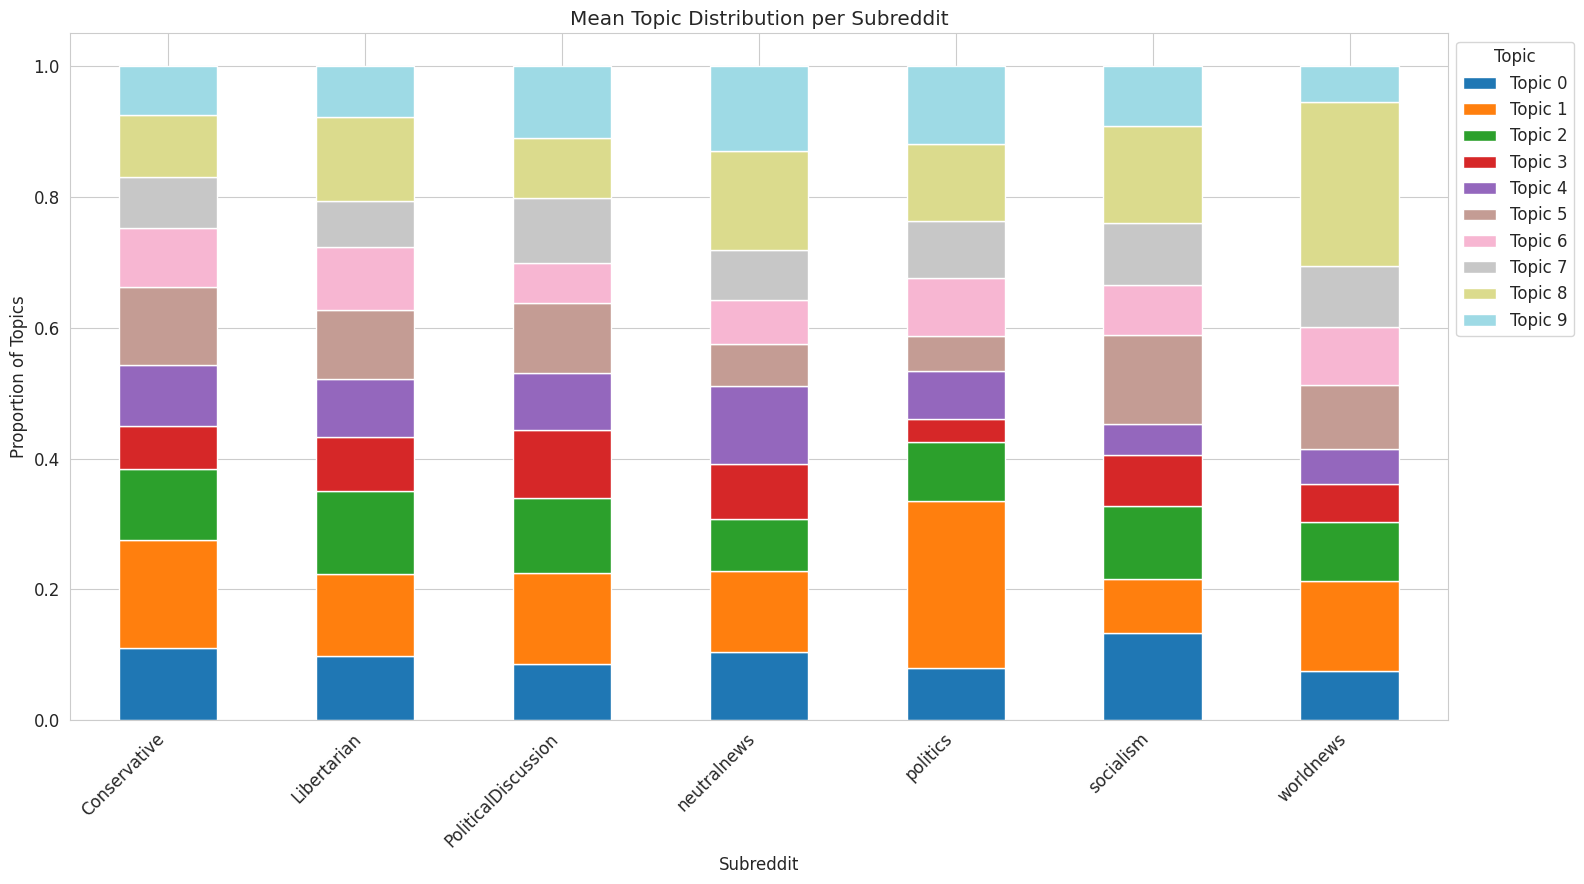

In [27]:
# 1. Get the topic distribution for each document in our balanced dataset
topic_dist = lda.transform(X_counts)

# 2. Create a DataFrame for easier analysis
topic_df = pd.DataFrame(topic_dist, columns=[f'Topic {i}' for i in range(10)])
topic_df['subreddit'] = y.values # 'y' holds the true labels for the balanced set

# 3. Calculate the mean topic distribution for each subreddit
# This tells us, on average, what each subreddit talks about.
mean_topic_dist = topic_df.groupby('subreddit').mean()

# 4. Visualize the results as a stacked bar chart
mean_topic_dist.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 9),
    colormap='tab20', # A color palette with many distinct colors
    title='Mean Topic Distribution per Subreddit'
)

plt.ylabel('Proportion of Topics')
plt.xlabel('Subreddit')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic', loc='upper left', bbox_to_anchor=(1, 1)) # Move legend outside
plt.tight_layout()
plt.show()

### Algorithm 7 (Outside-Class): Latent Dirichlet Allocation (LDA) on Comments

**Justification:** To complete our analysis, we will apply LDA to the comments data. This serves as a crucial point of comparison to the LDA on post titles. While titles represent the *initial framing* of information, comments represent the *community's reaction and discussion*. By uncovering the latent topics within the comments, we can identify the themes that truly engage the communities and see if they differ from the topics of the initial posts.

**Methodology:** The comments dataset is too large to process in its entirety. Therefore, we will take a large, **stratified random sample of 100,000 comments**. This ensures our sample is computationally manageable while accurately representing the proportional size of each subreddit. We will then use `CountVectorizer` and train an LDA model to find 10 "discussion topics" and visualize their distribution.

In [28]:
# --- Data Preparation for LDA on Comments ---

# 1. Load the full comments dataframe
comment_files = list(DATA_DIR.glob('*_comments.csv'))
comment_dfs = [pd.read_csv(f) for f in comment_files]
all_comments_df = pd.concat(comment_dfs, ignore_index=True)

# 2. Clean the comments data
# Drop rows with no text and remove common deleted/removed placeholders
comments_cleaned = all_comments_df.dropna(subset=['body'])
comments_cleaned = comments_cleaned[~comments_cleaned['body'].isin(['[deleted]', '[removed]'])]

print(f"Original number of comments: {len(all_comments_df):,}")
print(f"Number of valid comments after cleaning: {len(comments_cleaned):,}")

# 3. Perform stratified sampling to get 100,000 comments
sample_size = 100000
# We use train_test_split as a clever way to do stratified sampling
_, comments_sample = train_test_split(
    comments_cleaned,
    test_size=sample_size,
    stratify=comments_cleaned['subreddit'],
    random_state=RANDOM_STATE
)

print(f"\nSampled {len(comments_sample):,} comments for LDA analysis.")
print("Value counts in the sample:")
print(comments_sample['subreddit'].value_counts())

# 4. Prepare features (X) and target (y) for the sample
X_comments = comments_sample['body']
y_comments = comments_sample['subreddit']

Original number of comments: 1,309,066
Number of valid comments after cleaning: 1,055,791

Sampled 100,000 comments for LDA analysis.
Value counts in the sample:
subreddit
politics               68524
worldnews              23003
Conservative            4347
Libertarian             1639
socialism               1405
PoliticalDiscussion     1016
neutralnews               66
Name: count, dtype: int64


In [29]:
# --- LDA on Comments Implementation ---

# 1. Create a document-term matrix for the comments using CountVectorizer
print("\nCreating document-term matrix for comments...")
count_vectorizer_comments = CountVectorizer(stop_words='english', max_features=10000)
X_counts_comments = count_vectorizer_comments.fit_transform(X_comments)

# 2. Initialize and train the LDA model on the comment data
lda_comments = LatentDirichletAllocation(
    n_components=10,
    random_state=RANDOM_STATE
)
print("Training LDA model on comments... (This may take a few minutes)")
lda_comments.fit(X_counts_comments)
print("Training complete.")

# 3. Display the top words for each discovered "discussion topic"
print("\n--- Top 10 Words per Discussion Topic (LDA on Comments) ---")
display_topics(lda_comments, count_vectorizer_comments.get_feature_names_out(), 10)


Creating document-term matrix for comments...
Training LDA model on comments... (This may take a few minutes)
Training complete.

--- Top 10 Words per Discussion Topic (LDA on Comments) ---
Topic 0:
trump just epstein files time president did biden like going
Topic 1:
politics subreddit questions moderators com https wiki message automatically action
Topic 2:
fuck lol yeah oh good shit gonna just en let
Topic 3:
people government don just vote party money need state democrats
Topic 4:
like socialism sounds court including looks read space good kind
Topic 5:
https com www news politics reddit post article 2025 removed
Topic 6:
war russia ukraine just military russian like countries country china
Topic 7:
people right don just like left think want know say
Topic 8:
israel years people hamas old year women republican like children
Topic 9:
kirk just charlie like said people don know guy didn


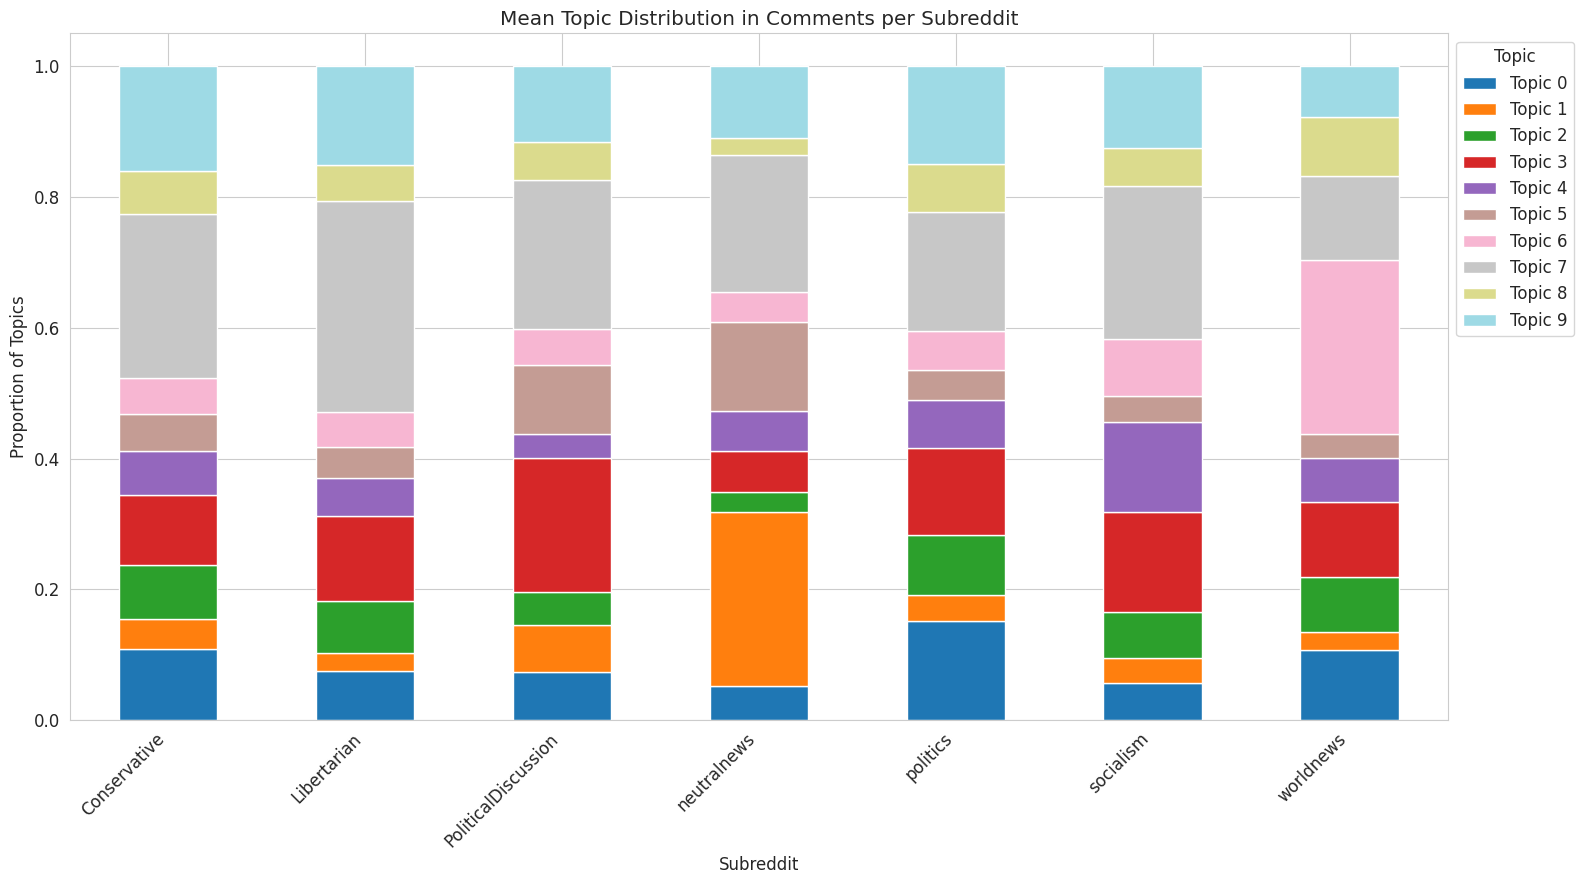

In [30]:
# --- Visualizing Comment Topic Distributions ---

# 1. Get the topic distribution for each comment in our sample
topic_dist_comments = lda_comments.transform(X_counts_comments)

# 2. Create a DataFrame for analysis
topic_df_comments = pd.DataFrame(topic_dist_comments, columns=[f'Topic {i}' for i in range(10)])
topic_df_comments['subreddit'] = y_comments.values

# 3. Calculate the mean topic distribution for each subreddit
mean_topic_dist_comments = topic_df_comments.groupby('subreddit').mean()

# 4. Visualize the results as a stacked bar chart
mean_topic_dist_comments.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 9),
    colormap='tab20',
    title='Mean Topic Distribution in Comments per Subreddit'
)

plt.ylabel('Proportion of Topics')
plt.xlabel('Subreddit')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()